In [14]:
from google.colab import drive
import os
import sys

drive.mount('/content/drive')


PROJECT_PATH = '/content/drive/MyDrive/HW_CV_Lesson5'

if not os.path.exists(PROJECT_PATH):
    os.makedirs(PROJECT_PATH)
    print(f"Папка {PROJECT_PATH} создана.")
else:
    print(f"Папка {PROJECT_PATH} найдена.")


%cd {PROJECT_PATH}

sys.path.append(PROJECT_PATH)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Папка /content/drive/MyDrive/HW_CV_Lesson5 найдена.
/content/drive/MyDrive/HW_CV_Lesson5


In [15]:
import zipfile
import os


zip_path = os.path.join(PROJECT_PATH, 'archives.zip')

extract_path = os.path.join(PROJECT_PATH, 'data')

if os.path.exists(zip_path):
    print(f"Распаковка {zip_path}...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("Распаковка завершена!")
else:
    print("Архив не найден!")

Распаковка /content/drive/MyDrive/HW_CV_Lesson5/archives.zip...
Распаковка завершена!


In [16]:
import os

# Ищем папку train внутри папки data
found_path = None
for root, dirs, files in os.walk("data"):
    if "train" in dirs:
        found_path = os.path.join(root, "train")
        print(f"Найдено'{found_path}'")
        break

if not found_path:
    print("Папка train не найдена")

Найдено'data/train'


In [17]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch
import torchvision
from torchvision import transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os
import time
from PIL import Image
import cv2
from tqdm import tqdm
import shutil

# Создаем папку для результатов
os.makedirs('results', exist_ok=True)

# Настройки для отображения графиков
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

In [18]:
import os
import torch
from torch.utils.data import Dataset
from PIL import Image
import numpy as np

class CustomImageDataset(Dataset):
    """Кастомный датасет для работы с папками классов"""

    def __init__(self, root_dir, transform=None, target_size=(224, 224)):
        """
        Args:
            root_dir (str): Путь к папке с классами
            transform: Аугментации для изображений
            target_size (tuple): Размер для ресайза изображений
        """
        self.root_dir = root_dir
        self.transform = transform
        self.target_size = target_size

        # Получаем список классов (папок)
        self.classes = sorted([d for d in os.listdir(root_dir)
                              if os.path.isdir(os.path.join(root_dir, d))])
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}

        # Собираем все пути к изображениям
        self.images = []
        self.labels = []

        for class_name in self.classes:
            class_dir = os.path.join(root_dir, class_name)
            class_idx = self.class_to_idx[class_name]

            for img_name in os.listdir(class_dir):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                    img_path = os.path.join(class_dir, img_name)
                    self.images.append(img_path)
                    self.labels.append(class_idx)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]

        # Загружаем изображение
        image = Image.open(img_path).convert('RGB')

        # Ресайзим изображение
        image = image.resize(self.target_size, Image.Resampling.LANCZOS)

        # Применяем аугментации
        if self.transform:
            image = self.transform(image)

        return image, label

    def get_class_names(self):
        """Возвращает список имен классов"""
        return self.classes

In [19]:
def show_images(images, labels=None, nrow=8, title=None, size=128):
    """Визуализирует батч изображений."""
    images = images[:nrow]

    # Увеличиваем изображения до 128x128 для лучшей видимости
    resize_transform = transforms.Resize((size, size), antialias=True)
    images_resized = [resize_transform(img) for img in images]

    # Создаем сетку изображений
    fig, axes = plt.subplots(1, nrow, figsize=(nrow*2, 2))
    if nrow == 1:
        axes = [axes]

    for i, img in enumerate(images_resized):
        img_np = img.numpy().transpose(1, 2, 0)
        # Нормализуем для отображения
        img_np = np.clip(img_np, 0, 1)
        axes[i].imshow(img_np)
        axes[i].axis('off')
        if labels is not None:
            axes[i].set_title(f'Label: {labels[i]}')

    if title:
        fig.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()

def show_single_augmentation(original_img, augmented_img, title="Аугментация"):
    """Визуализирует оригинальное и аугментированное изображение рядом."""
    import numpy as np
    import torch
    from PIL import Image
    import matplotlib.pyplot as plt
    import torchvision.transforms as transforms

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

    # Resize to 128×128
    resize_transform = transforms.Resize((128, 128), antialias=True)
    orig_resized = resize_transform(original_img)
    aug_resized = resize_transform(augmented_img)

    def to_numpy(img):
        """Конвертирует PIL или Tensor → numpy(H, W, C)."""
        if isinstance(img, torch.Tensor):
            # Tensor shape: [C, H, W]
            arr = img.detach().cpu().numpy().transpose(1, 2, 0)
            return np.clip(arr, 0, 1)
        elif isinstance(img, Image.Image):
            # PIL → numpy
            arr = np.array(img)
            # Если PIL в uint8 — нормируем
            if arr.max() > 1:
                arr = arr / 255.0
            return arr
        else:
            raise TypeError(f"Unsupported type: {type(img)}")

    ax1.imshow(to_numpy(orig_resized))
    ax1.set_title("Оригинал")
    ax1.axis("off")

    ax2.imshow(to_numpy(aug_resized))
    ax2.set_title(title)
    ax2.axis("off")

    plt.tight_layout()
    plt.show()


def show_multiple_augmentations(original_img, augmented_imgs, titles):
    """
    Показывает оригинал + несколько аугментированных изображений.
    Поддерживает как PIL.Image, так и torch.Tensor.
    """
    import numpy as np
    import torch
    from PIL import Image
    import matplotlib.pyplot as plt
    import torchvision.transforms as transforms

    n = len(augmented_imgs)
    fig, axes = plt.subplots(1, n + 1, figsize=(4 * (n + 1), 4))

    resize_transform = transforms.Resize((128, 128), antialias=True)
    orig_resized = resize_transform(original_img)

    def to_numpy(img):
        """Приведение PIL или Tensor → numpy (H, W, C)."""
        if isinstance(img, torch.Tensor):
            arr = img.detach().cpu().numpy().transpose(1, 2, 0)
            return np.clip(arr, 0, 1)
        elif isinstance(img, Image.Image):
            arr = np.array(img)
            if arr.max() > 1:
                arr = arr / 255.0
            return arr
        else:
            raise TypeError(f"Unsupported type: {type(img)}")

    # Оригинал
    axes[0].imshow(to_numpy(orig_resized))
    axes[0].set_title("Оригинал")
    axes[0].axis("off")

    # Аугментированные изображения
    for i, (aug, title) in enumerate(zip(augmented_imgs, titles), start=1):
        aug_resized = resize_transform(aug)
        axes[i].imshow(to_numpy(aug_resized))
        axes[i].set_title(title)
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()


## Задание 1: Стандартные аугментации torchvision (15 баллов)

1. Создайте пайплайн стандартных аугментаций torchvision (например, RandomHorizontalFlip, RandomCrop, ColorJitter, RandomRotation, RandomGrayscale).
2. Примените аугментации к 5 изображениям из разных классов (папка train).
3. Визуализируйте:
   - Оригинал
   - Результат применения каждой аугментации отдельно
   - Результат применения всех аугментаций вместе

Найдено 5 изображений из разных классов
Визуализация отдельных аугментаций:


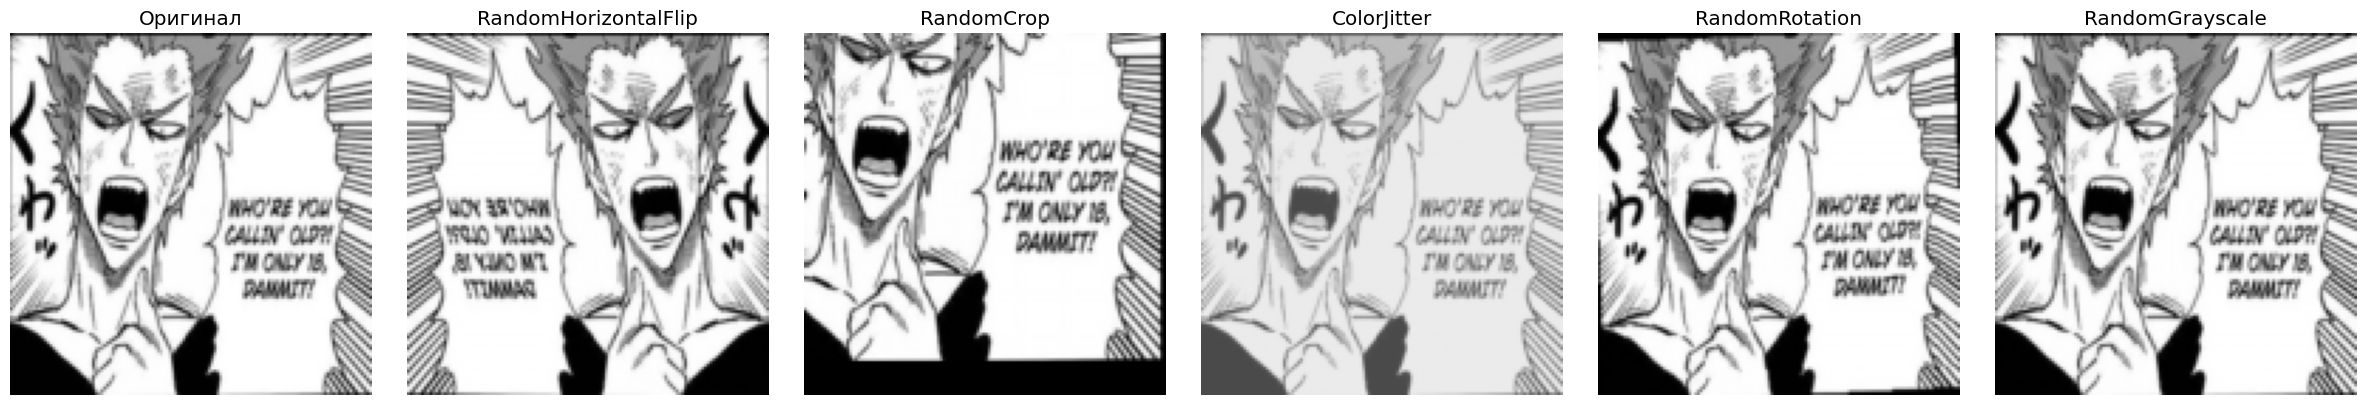

Визуализация всех аугментаций вместе:


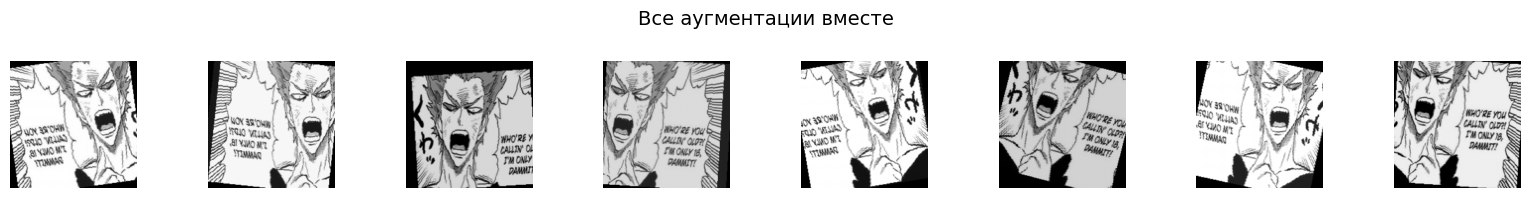

In [20]:
root = 'data/train'
dataset = CustomImageDataset(root, transform=None, target_size=(224, 224))

# Берем 5 изображений из разных классов
sample_images = []
sample_labels = []
seen_classes = set()

for i in range(len(dataset)):
    img, label = dataset[i]
    if label not in seen_classes:
        sample_images.append(img)
        sample_labels.append(label)
        seen_classes.add(label)
    if len(seen_classes) >= 5:
        break

print(f"Найдено {len(sample_images)} изображений из разных классов")

# Определяем стандартные аугментации
standard_augs = [
    ("RandomHorizontalFlip", transforms.RandomHorizontalFlip(p=1.0)),
    ("RandomCrop", transforms.RandomCrop(200, padding=20)),
    ("ColorJitter", transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1)),
    ("RandomRotation", transforms.RandomRotation(degrees=30)),
    ("RandomGrayscale", transforms.RandomGrayscale(p=1.0))
]

# Применяем каждую аугментацию отдельно к первому изображению
original_img = sample_images[0]
augmented_imgs = []
titles = []

for name, aug in standard_augs:
    aug_transform = transforms.Compose([
        aug,
        transforms.ToTensor()
    ])
    aug_img = aug_transform(original_img)
    augmented_imgs.append(aug_img)
    titles.append(name)

# Визуализируем отдельные аугментации
print("Визуализация отдельных аугментаций:")
show_multiple_augmentations(original_img, augmented_imgs, titles)

# Применяем все аугментации вместе
print("Визуализация всех аугментаций вместе:")
combined_aug = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomCrop(200, padding=20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor()
])

combined_imgs = []
for i in range(8):
    combined_img = combined_aug(original_img)
    combined_imgs.append(combined_img)

show_images(combined_imgs, title="Все аугментации вместе")


## Задание 2: Кастомные аугментации (20 баллов)

1. Реализуйте минимум 3 кастомные аугментации (например, случайное размытие, случайная перспектива, случайная яркость/контрастность).
2. Примените их к изображениям из train.
3. Сравните визуально с готовыми аугментациями из extra_augs.py.

Визуализация кастомных аугментаций:


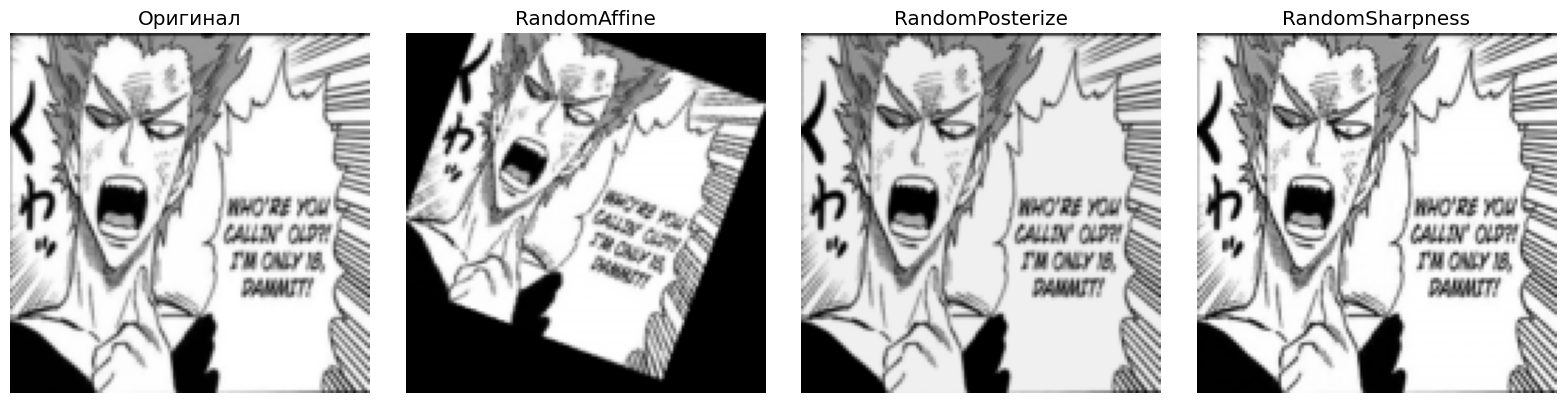

In [21]:
from torchvision import transforms


class CustomRandomAffine:
    """Случайная аффинная трансформация"""
    def __init__(self, p=0.5, degrees=30, translate=(0.1, 0.1), scale=(0.8, 1.2)):
        self.p = p
        self.transform = transforms.RandomAffine(degrees=degrees, translate=translate, scale=scale)

    def __call__(self, img):
        if np.random.random() > self.p:
            return img
        return self.transform(img)

class CustomRandomPosterize:
    """Случайная потеризация"""
    def __init__(self, p=0.5, bits=4):
        self.p = p
        self.transform = transforms.RandomPosterize(bits=bits, p=1.0)

    def __call__(self, img):
        if np.random.random() > self.p:
            return img
        return self.transform(img)

class CustomRandomAdjustSharpness:
    """Случайное изменение резкости"""
    def __init__(self, p=0.5, sharpness_factor=2):
        self.p = p
        self.transform = transforms.RandomAdjustSharpness(sharpness_factor=sharpness_factor, p=1.0)

    def __call__(self, img):
        if np.random.random() > self.p:
            return img
        return self.transform(img)

# Применяем кастомные аугментации
original_img = sample_images[0]

custom_augs = [
    ("RandomAffine", CustomRandomAffine(p=1.0)),
    ("RandomPosterize", CustomRandomPosterize(p=1.0)),
    ("RandomSharpness", CustomRandomAdjustSharpness(p=1.0))
]

custom_augmented_imgs = []
custom_titles = []

for name, aug in custom_augs:
    aug_img = aug(original_img)
    aug_img_tensor = transforms.ToTensor()(aug_img)
    custom_augmented_imgs.append(aug_img_tensor)
    custom_titles.append(name)

print("Визуализация кастомных аугментаций:")
show_multiple_augmentations(original_img, custom_augmented_imgs, custom_titles)


## Задание 3: Анализ датасета (10 баллов)

1. Подсчитайте количество изображений в каждом классе.
2. Найдите минимальный, максимальный и средний размеры изображений.
3. Визуализируйте распределение размеров и гистограмму по классам.

Количество изображений по классам:
  Гароу: 30 изображений
  Генос: 30 изображений
  Сайтама: 30 изображений
  Соник: 30 изображений
  Татсумаки: 30 изображений
  Фубуки: 30 изображений

Анализ размеров изображений:
  Минимальная ширина: 210
  Максимальная ширина: 736
  Средняя ширина: 538.89
  Минимальная высота: 240
  Максимальная высота: 1308
  Средняя высота: 623.56


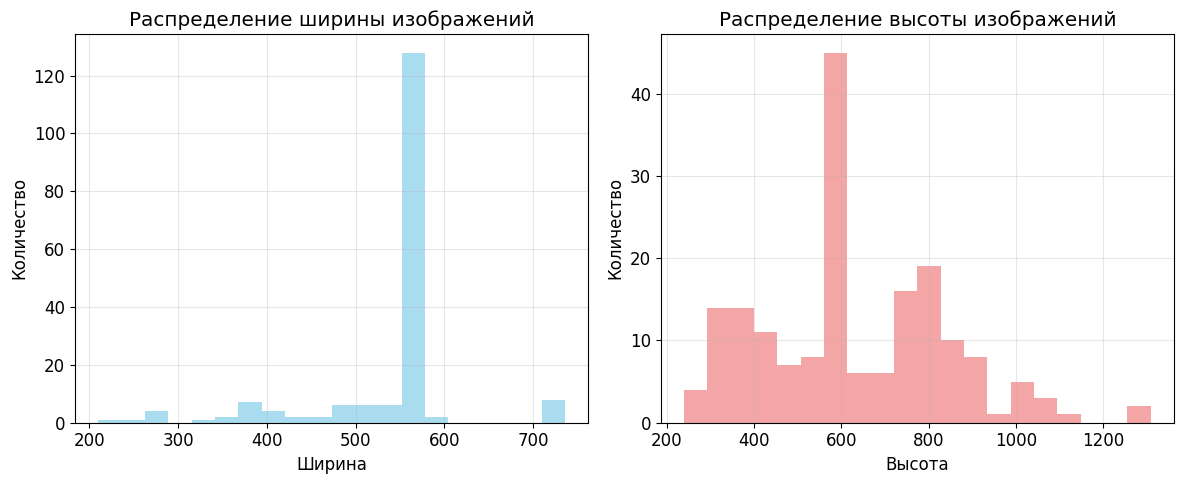

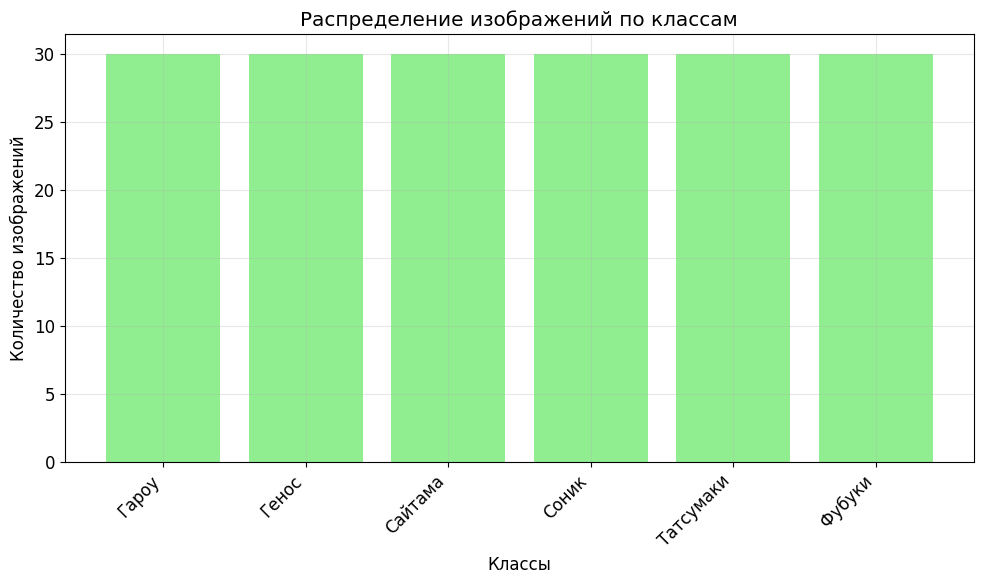

In [22]:
# Подсчет количества изображений в каждом классе
class_counts = {}
class_names = dataset.get_class_names()

for label in dataset.labels:
    class_name = class_names[label]
    if class_name not in class_counts:
        class_counts[class_name] = 0
    class_counts[class_name] += 1

print("Количество изображений по классам:")
for class_name, count in class_counts.items():
    print(f"  {class_name}: {count} изображений")

# Анализ размеров изображений
widths = []
heights = []

for img_path in dataset.images:
    with Image.open(img_path) as img:
        widths.append(img.width)
        heights.append(img.height)

print(f"\nАнализ размеров изображений:")
print(f"  Минимальная ширина: {min(widths)}")
print(f"  Максимальная ширина: {max(widths)}")
print(f"  Средняя ширина: {np.mean(widths):.2f}")
print(f"  Минимальная высота: {min(heights)}")
print(f"  Максимальная высота: {max(heights)}")
print(f"  Средняя высота: {np.mean(heights):.2f}")

# Визуализация распределения размеров
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.hist(widths, bins=20, alpha=0.7, color='skyblue')
ax1.set_xlabel('Ширина')
ax1.set_ylabel('Количество')
ax1.set_title('Распределение ширины изображений')
ax1.grid(True, alpha=0.3)

ax2.hist(heights, bins=20, alpha=0.7, color='lightcoral')
ax2.set_xlabel('Высота')
ax2.set_ylabel('Количество')
ax2.set_title('Распределение высоты изображений')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/image_sizes_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# Визуализация гистограммы по классам
plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values(), color='lightgreen')
plt.xlabel('Классы')
plt.ylabel('Количество изображений')
plt.title('Распределение изображений по классам')
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('results/class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()


## Задание 4: Pipeline аугментаций (20 баллов)

1. Реализуйте класс AugmentationPipeline с методами:
   - add_augmentation(name, aug)
   - remove_augmentation(name)
   - apply(image)
   - get_augmentations()
2. Создайте несколько конфигураций (light, medium, heavy).
3. Примените каждую конфигурацию к train и сохраните результаты.

In [23]:
class AugmentationPipeline:
    def __init__(self):
        self.augs = {}

    def add_augmentation(self, name, aug):
        self.augs[name] = aug

    def remove_augmentation(self, name):
        if name in self.augs:
            del self.augs[name]

    def get_compose(self):
        # Превращаем словарь в список для transforms.Compose
        # Всегда добавляем ToTensor в конце для обучения
        aug_list = list(self.augs.values())
        aug_list.append(transforms.ToTensor())
        return transforms.Compose(aug_list)

# Конфигурации
light = AugmentationPipeline()
light.add_augmentation('flip', transforms.RandomHorizontalFlip())
light.add_augmentation('resize', transforms.Resize((64, 64)))

heavy = AugmentationPipeline()
heavy.add_augmentation('flip', transforms.RandomHorizontalFlip())
heavy.add_augmentation('rotate', transforms.RandomRotation(45))
heavy.add_augmentation('color', transforms.ColorJitter(0.5, 0.5))
heavy.add_augmentation('resize', transforms.Resize((224, 224)))

print("Pipelines созданы (Light и Heavy).")

Pipelines созданы (Light и Heavy).


## Задание 5: Эксперимент с размерами (10 баллов)

1. Проведите эксперимент с разными размерами изображений (например, 64x64, 128x128, 224x224, 512x512).
2. Для каждого размера измерьте время загрузки и применения аугментаций к 100 изображениям, а также потребление памяти.
3. Постройте графики зависимости времени и памяти от размера.

Тестируем размер: 64x64
  Время загрузки: 3.47 сек
  Время аугментаций: 0.21 сек
  Память: 4.69 МБ
Тестируем размер: 128x128
  Время загрузки: 3.53 сек
  Время аугментаций: 0.41 сек
  Память: 18.75 МБ
Тестируем размер: 224x224
  Время загрузки: 2.47 сек
  Время аугментаций: 0.56 сек
  Память: 57.42 МБ
Тестируем размер: 512x512
  Время загрузки: 3.14 сек
  Время аугментаций: 1.33 сек
  Память: 300.00 МБ


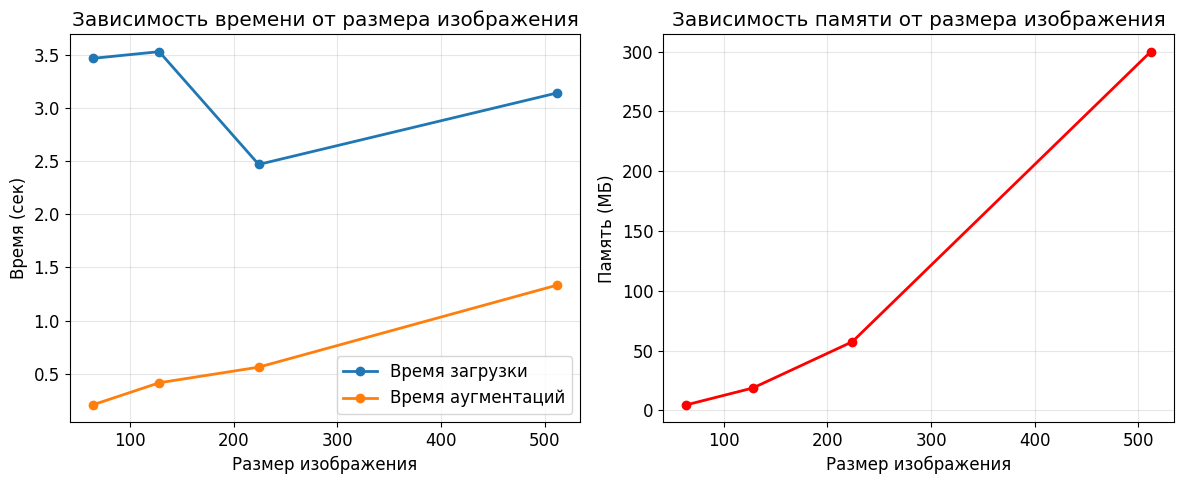

Задание 5 завершено!


In [ ]:
sizes = [64, 128, 224, 512]
results = []

# Создаем тестовый пайплайн аугментаций
test_pipeline = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor()
])

for size in sizes:
    print(f"Тестируем размер: {size}x{size}")

    # Загружаем датасет с текущим размером
    dataset = CustomImageDataset('data/train', transform=None, target_size=(size, size))

    # Берем 100 изображений для теста
    test_indices = list(range(min(100, len(dataset))))

    # Измеряем время загрузки
    start_time = time.time()
    loaded_images = []
    for idx in test_indices:
        img, _ = dataset[idx]
        loaded_images.append(img)
    load_time = time.time() - start_time

    # Измеряем время применения аугментаций
    start_time = time.time()
    augmented_images = []
    for img in loaded_images:
        augmented_img = test_pipeline(img)
        augmented_images.append(augmented_img)
    aug_time = time.time() - start_time

    # Измеряем потребление памяти
    memory_usage = sum([img.element_size() * img.nelement() for img in augmented_images]) / (1024 * 1024)  # в МБ

    results.append({
        'size': size,
        'load_time': load_time,
        'aug_time': aug_time,
        'memory_usage': memory_usage
    })

    print(f"  Время загрузки: {load_time:.2f} сек")
    print(f"  Время аугментаций: {aug_time:.2f} сек")
    print(f"  Память: {memory_usage:.2f} МБ")

# Визуализируем результаты
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

sizes_list = [r['size'] for r in results]
load_times = [r['load_time'] for r in results]
aug_times = [r['aug_time'] for r in results]
memory_usage = [r['memory_usage'] for r in results]

# График времени
ax1.plot(sizes_list, load_times, 'o-', label='Время загрузки', linewidth=2)
ax1.plot(sizes_list, aug_times, 'o-', label='Время аугментаций', linewidth=2)
ax1.set_xlabel('Размер изображения')
ax1.set_ylabel('Время (сек)')
ax1.set_title('Зависимость времени от размера изображения')
ax1.legend()
ax1.grid(True, alpha=0.3)

# График памяти
ax2.plot(sizes_list, memory_usage, 'o-', color='red', linewidth=2)
ax2.set_xlabel('Размер изображения')
ax2.set_ylabel('Память (МБ)')
ax2.set_title('Зависимость памяти от размера изображения')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/size_experiment.png', dpi=300, bbox_inches='tight')
plt.show()

## Задание 6: Дообучение предобученных моделей (25 баллов)

1. Возьмите одну из предобученных моделей torchvision (например, resnet18, efficientnet_b0, mobilenet_v3_small).
2. Замените последний слой на количество классов вашего датасета.
3. Дообучите модель на train, проверьте качество на val.
4. Визуализируйте процесс обучения (loss/accuracy).

In [25]:
import os
import shutil
import random

# Настройки
data_root = 'data'
val_ratio = 0.3  # 30% в val

# Создаем папку val
val_dir = os.path.join(data_root, 'val')
os.makedirs(val_dir, exist_ok=True)

# Копируем изображения
train_dir = os.path.join(data_root, 'train')
classes = os.listdir(train_dir)

total_copied = 0

for class_name in classes:
    class_train = os.path.join(train_dir, class_name)
    class_val = os.path.join(val_dir, class_name)

    if not os.path.isdir(class_train):
        continue

    os.makedirs(class_val, exist_ok=True)

    images = [f for f in os.listdir(class_train)
             if f.endswith(('.jpg', '.png', '.jpeg'))]

    val_count = max(1, int(len(images) * val_ratio))
    val_images = random.sample(images, val_count)

    for img in val_images:
        src = os.path.join(class_train, img)
        dst = os.path.join(class_val, img)
        shutil.copy2(src, dst)
        total_copied += 1

    print(f"{class_name}: {len(val_images)} изображений -> val")


Фубуки: 9 изображений -> val
Татсумаки: 9 изображений -> val
Соник: 9 изображений -> val
Сайтама: 9 изображений -> val
Генос: 9 изображений -> val
Гароу: 9 изображений -> val


Используемое устройство: cpu
Классов: 6
Изображений в train: 180
Изображений в val: 54
Модель создана!
Начинаем обучение...

Эпоха 1/5


Валидация: 100%|██████████| 2/2 [00:05<00:00,  2.87s/it]


Train Loss: 1.9585, Train Acc: 18.33%
Val Loss: 1.7867, Val Acc: 27.78%

Эпоха 2/5


Валидация: 100%|██████████| 2/2 [00:05<00:00,  2.86s/it]


Train Loss: 1.7434, Train Acc: 28.33%
Val Loss: 1.7021, Val Acc: 25.93%

Эпоха 3/5


Валидация: 100%|██████████| 2/2 [00:06<00:00,  3.15s/it]


Train Loss: 1.5714, Train Acc: 42.22%
Val Loss: 1.5098, Val Acc: 51.85%

Эпоха 4/5


Валидация: 100%|██████████| 2/2 [00:06<00:00,  3.45s/it]


Train Loss: 1.4517, Train Acc: 52.78%
Val Loss: 1.3618, Val Acc: 64.81%

Эпоха 5/5


Валидация: 100%|██████████| 2/2 [00:07<00:00,  3.80s/it]


Train Loss: 1.3497, Train Acc: 58.89%
Val Loss: 1.2755, Val Acc: 68.52%
Обучение завершено!


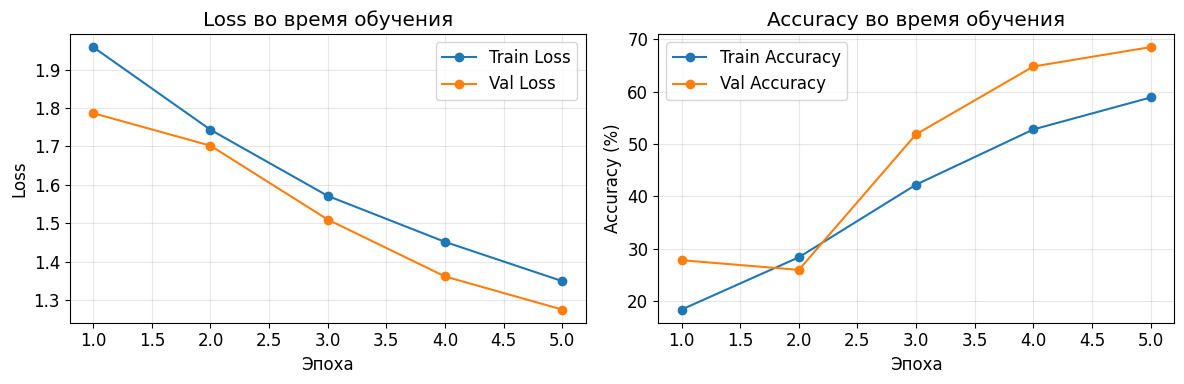

In [27]:
# Проверяем доступность GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Используемое устройство: {device}")

# Подготовка данных
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
])

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Загружаем датасеты
train_dataset = CustomImageDataset('data/train', transform=transform_train)
val_dataset = CustomImageDataset('data/val', transform=transform_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print(f"Классов: {len(train_dataset.get_class_names())}")
print(f"Изображений в train: {len(train_dataset)}")
print(f"Изображений в val: {len(val_dataset)}")

# Создаем модель
def create_model(num_classes):
    """Создает и настраивает модель ResNet18"""
    model = models.resnet18(weights='IMAGENET1K_V1')

    # Замораживаем все слои кроме последнего
    for param in model.parameters():
        param.requires_grad = False

    # Заменяем последний слой
    model.fc = torch.nn.Linear(model.fc.in_features, num_classes)

    # Размораживаем последний слой
    for param in model.fc.parameters():
        param.requires_grad = True

    return model

num_classes = len(train_dataset.get_class_names())
model = create_model(num_classes)
model = model.to(device)

print("Модель создана!")

# Функции для обучения
def train_epoch(model, loader, optimizer, loss_fn, device):
    """Одна эпоха обучения"""
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for x, y in tqdm(loader, desc="Обучение"):
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        outputs = model(x)
        loss = loss_fn(outputs, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += y.size(0)
        correct += (predicted == y).sum().item()

    accuracy = 100 * correct / total
    avg_loss = total_loss / len(loader)

    return avg_loss, accuracy

def validate_epoch(model, loader, loss_fn, device):
    """Валидация модели"""
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for x, y in tqdm(loader, desc="Валидация"):
            x, y = x.to(device), y.to(device)

            outputs = model(x)
            loss = loss_fn(outputs, y)

            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += y.size(0)
            correct += (predicted == y).sum().item()

    accuracy = 100 * correct / total
    avg_loss = total_loss / len(loader)

    return avg_loss, accuracy

# Обучение модели
print("Начинаем обучение...")

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

num_epochs = 5

for epoch in range(num_epochs):
    print(f"\nЭпоха {epoch+1}/{num_epochs}")

    # Обучение
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_fn, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Валидация
    val_loss, val_acc = validate_epoch(model, val_loader, loss_fn, device)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

print("Обучение завершено!")

# Визуализация процесса обучения
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, 'o-', label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, 'o-', label='Val Loss')
plt.xlabel('Эпоха')
plt.ylabel('Loss')
plt.title('Loss во время обучения')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, 'o-', label='Train Accuracy')
plt.plot(range(1, num_epochs+1), val_accuracies, 'o-', label='Val Accuracy')
plt.xlabel('Эпоха')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy во время обучения')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

# Сохраняем модель
torch.save(model.state_dict(), 'results/hero_classifier.pth')